# 決定木・ランダムフォレスト

$$
IG(D_p, f) \equiv I(D_p) - \displaystyle \sum_{j=1}^m \cfrac{N_j}{N_p} I(D_j)
$$

$$
IG(D_p, f)
$$

$$
I_H = - \displaystyle \sum_c p(c) \log_{2} p(c)
$$

$$
I_G = 1 - \displaystyle \sum_c p(c)^2
$$

$$
I_E = 1 - \max p(c)
$$

情報利得（Information Gain）= 親ノードと子ノードの不純度（Impurity）の差

不純度（Impurity）= その集団に、異なるクラスラベルのサンプルがどの程度の割合で混ざっているかを表す指標。純粋（サンプル全てが同じクラスラベル）に近いほど低くなる

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np

In [4]:
def plot(classifier, data, labels, title=None, xlabel=None, ylabel=None):
    colors = ['red', 'blue']
    x1max, x1min = np.max(data[:, 0]), np.min(data[:, 0])
    x2max, x2min = np.max(data[:, 1]), np.min(data[:, 1])
    scale_x1 = x1max - x1min
    scale_x2 = x2max - x2min
    x1max, x1min = x1max + (x1max-x1min)*0.05, x1min - (x1max-x1min)*0.05
    x2max, x2min = x2max + (x2max-x2min)*0.05, x2min - (x2max-x2min)*0.05
    resolution = scale_x1 / 300
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, resolution), np.arange(x2min, x2max, resolution))
    z = np.array([classifier.predict(x) for x in np.array([xx1.ravel(), xx2.ravel()]).T])
    z = z.reshape(xx1.shape)
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=ListedColormap(colors[::-1]))
    
    data_of_each_label = [[], []]
    for d, l in zip(data, labels):
        if l == 1:
            data_of_each_label[0].append(d)
        else:
            data_of_each_label[1].append(d)
    for i in range(len(data_of_each_label)):
        plt.scatter(np.array(data_of_each_label[i])[:, 0], np.array(data_of_each_label[i])[:, 1], s=5, c=colors[i])
    plt.show()

In [14]:
from graphviz import Graph
from graphviz import Digraph

def draw_decision_tree(tree_):
    dg = Digraph(format='png', engine='dot')
    stack = [(tree_.root, 'root')]
    while len(stack) > 0:
        node, name = stack.pop()
        if node.threshold is None:
            message = str(node.label)
            dg.node(name, message, style='filled', fontcolor='white', fillcolor='red' if node.label==1 else 'blue')
        else:
            message = 'x{} <\n{}'.format(node.i_feature+1, node.threshold)
            dg.node(name, message)
        if node.left is not None:
            name_to = '{}_l'.format(name)
            stack.append((node.left, name_to))
            dg.edge(name, name_to, 'Yes')
        if node.right is not None:
            name_to = '{}_r'.format(name)
            stack.append((node.right, name_to))
            dg.edge(name, name_to, 'No')
    return dg

In [4]:
import numpy as np

class MyNode:
    def __init__(self, label, i_feature=None, threshold=None):
        """
        Parameters
        ----------
        label : ノードの代表ラベル
        i_feature : 判定に用いる特徴量のインデックス
        threshold : 判別閾値
        """
        self.left = None
        self.right = None
        self.i_feature = i_feature
        self.threshold = threshold
        self.label = label
    
    def is_leaf(self):
        return self.threshold is None

class DecisionTree:
    def __init__(self, min_sample_leaf=1):
        """
        Parameters
        ----------
        min_sample_leaf : 学習時、1枚の葉が持つべきデータサンプルの最小件数
        """
        self.root = None
        self.min_sample_leaf = min_sample_leaf

    def predict(self, x):
        """
        Parameters
        ----------
        x : 分類したいデータ（d次元ベクトル）
        """
        stack = [self.root]
        while len(stack) > 0:
            node = stack.pop()
            if node.left is None:
                return node.label
            if x[node.i_feature] < node.threshold:
                stack.append(node.left)
            else:
                stack.append(node.right)
    
    def fit(self, data, labels):
        self.root = self.__dfs(data, labels)
    
    def __dfs(self, data, labels):
        """
        与えられたデータセットを、情報利得が最大となるよう再帰的に分割
        """
        inpurity = self.__inpurity(labels.tolist())
        found_best = False
        best_gain = - float('inf')
        for i_f in range(len(data[0])):
            data_f = np.unique(data[:, i_f])  # 重複削除 & ソート
            th_arr = (data_f[:-1] + data_f[1:]) / 2.0  # 閾値候補として中間の値を取る
            for i_th in range(len(th_arr)):
                d_l, d_r = [], []
                l_l, l_r = [], []
                for j in range(len(data)):
                    if data[j][i_f] < th_arr[i_th]:
                        d_l.append(data[j])
                        l_l.append(labels[j])
                    else:
                        d_r.append(data[j])
                        l_r.append(labels[j])
                inpurity_l = self.__inpurity(l_l)
                inpurity_r = self.__inpurity(l_r)
                gain = inpurity - inpurity_l*len(d_l)/len(data) - inpurity_r*len(d_r)/len(data)
                if gain > best_gain and len(d_l) >= self.min_sample_leaf and len(d_r) >= self.min_sample_leaf:
                    best_gain = gain
                    best_threshold = th_arr[i_th]
                    best_i_feature = i_f
                    best_data_left, best_data_right = d_l, d_r
                    best_labels_left, best_labels_right = l_l, l_r
                    found_best = True

        node_label = self.__representative_label(labels)
        # 一度も条件を満たす gain が得られなかった
        if not found_best or best_gain == 0:
            return MyNode(node_label)
        
        node = MyNode(node_label, best_i_feature, best_threshold)
        node.left = self.__dfs(np.array(best_data_left), np.array(best_labels_left))
        node.right = self.__dfs(np.array(best_data_right), np.array(best_labels_right))
        
        # 左と右が共に葉で同じラベルなら枝刈りして自分を葉にする
        if node.left.is_leaf() and node.right.is_leaf() and node.left.label == node.right.label:
            node = MyNode(node_label)

        return node
    
    def __inpurity(self, labels):
        """
        与えられたラベルの集合の不純度（ジニ不純度）を計算
        """
        cnt = {}
        for l in labels:
            if l not in cnt:
                cnt[l] = 1
            else:
                cnt[l] += 1
        inp = 1.0
        for l in cnt:
            rate_l = cnt[l] / len(labels)
            inp -= rate_l**2
        return inp
    
    def __representative_label(self, labels):
        """
        多数決で代表ラベルを決める
        """
        cnt = {}
        for l in labels:
            if l not in cnt:
                cnt[l] = 1
            else:
                cnt[l] += 1
        # NOTE: 同率1位は気にしない
        return max(cnt, key=cnt.get)

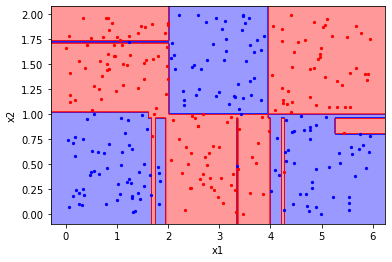

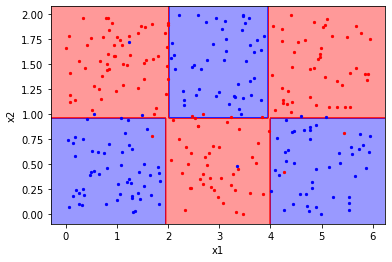

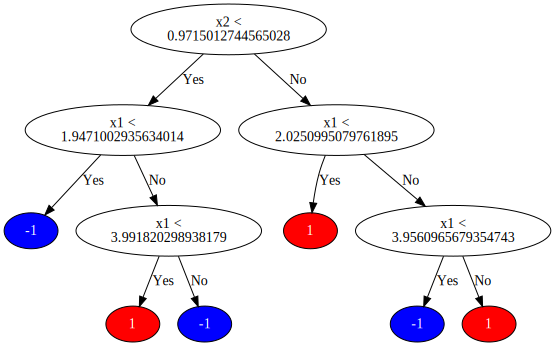

In [5]:
# 学習データ作成
N = 300
A = 6
B = 2
x = np.random.rand(N) * A
y = np.random.rand(N) * B
data = np.array([x, y]).T
def get_label(d_):
    tmp_ = (d_[0] // (A/3) + d_[1] // (B/2)) % 2
    return 1 if tmp_ == 1 else -1
labels = np.array([get_label(data[i]) for i in range(N)])
# 外れ値を入れる
for i in range(N//50):
    labels[i] = -1 if labels[i] == 1 else 1

# 学習（枝刈りなし）
tree = DecisionTree(1)
tree.fit(data, labels)
plot(tree, data, labels, None, 'x1', 'x2')

# 学習
tree = DecisionTree(10)
tree.fit(data, labels)
plot(tree, data, labels, None, 'x1', 'x2')

# 決定木の描画
dg = draw_decision_tree(tree)
dg.render('graph-decision-tree-square')
dg

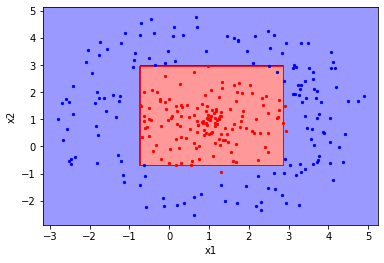

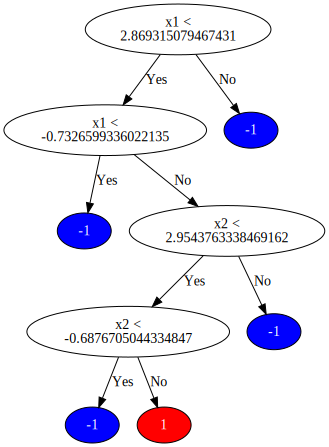

In [6]:
# 学習データ作成
R1 = 2
R2 = 4
R_MARGIN = 0.3
C = (1,1)

N = 300
r1 = R1*np.random.rand(N//2)
r2 = (R2-R1-R_MARGIN)*np.random.rand(N//2) + R1 + R_MARGIN
theta1 = np.random.rand(N//2) * 2 * np.pi
theta2 = np.random.rand(N//2) * 2 * np.pi
data1 = np.array([r1 * np.sin(theta1) + C[0], r1 * np.cos(theta1) + C[1]]).T
data2 = np.array([r2 * np.sin(theta2) + C[0], r2 * np.cos(theta2) + C[1]]).T
data = np.concatenate([data1, data2])
labels = np.array([1 if i < N//2 else -1 for i in range(N)])

# 学習
tree = DecisionTree(10)
tree.fit(data, labels)
plot(tree, data, labels, None, 'x1', 'x2')

# 決定木の描画
dg = draw_decision_tree(tree)
dg.render('graph-decision-tree-circle')
dg

In [7]:
import random

class RandomForest:
    def __init__(self, n_feature, n_sample, n_tree, min_sample_leaf=1):
        self.n_feature = n_feature
        self.n_sample = n_sample
        self.n_tree = n_tree
        self.min_sample_leaf = min_sample_leaf
    
    def predict(self, x):
        cnt = {}
        for i in range(self.n_tree):
            x_fixed = x[self.feature_indices[i]]
            label = self.trees[i].predict(x_fixed)
            if label not in cnt:
                cnt[label] = 1
            else:
                cnt[label] += 1
        # NOTE: 同率1位は気にしない
        label = max(cnt, key=cnt.get)
        return label

    def fit(self, data, labels):
        self.feature_indices = []
        self.trees = []
        d = len(data[0])
        for _ in range(self.n_tree):
            data_indices = random.sample(list(range(len(data))), self.n_sample)
            feature_indices = random.sample(list(range(d)), self.n_feature)
            sampled_data = data[data_indices][:, feature_indices]
            sampled_labels = labels[data_indices]
            tree = DecisionTree(self.min_sample_leaf)
            tree.fit(sampled_data, sampled_labels)
            self.feature_indices.append(feature_indices)
            self.trees.append(tree)

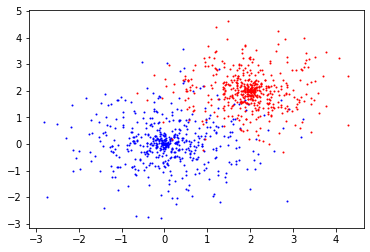

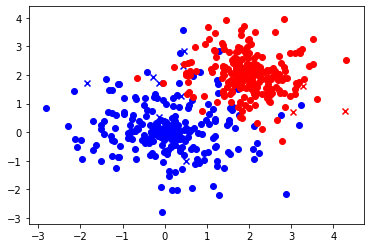

In [8]:
# 学習データ作成（部分的に重なるd次元球2つ）
d = 6
C1 = [0] * d
C2 = [2] * d
# 一部の特徴量では C1 との差がつかないようにする
C2[2], C2[4] = 0, 0
# 一部の特徴量では C1 と分離しやすくする
C2[3] = 3
R1 = 4
R2 = 3
N = 1000
r1 = R1*np.random.rand(N//2)
r2 = R2*np.random.rand(N//2)
def sphere(r_, n_, d_, c_):
    data_ = np.random.normal(0, 1, (n_, d_))
    data_ = data_.T / np.sqrt(np.sum(data_*data_, axis=1)) * r_
    data_ = data_.T + c_
    return data_
data1 = sphere(r1, N//2, d, C1)
data2 = sphere(r2, N//2, d, C2)
data = np.concatenate([data1, data2])
labels = np.array([1 if i < N//2 else -1 for i in range(N)])
plt.scatter(data1[:,0], data1[:,1], s=1, c='b')
plt.scatter(data2[:,0], data2[:,1], s=1, c='r')
plt.show()

data_l, data_t = data[0::2], data[1::2]
labels_l, labels_t = labels[0::2], labels[1::2]

rf = RandomForest(3, 100, 9, 10)
rf.fit(data_l, labels_l)

colors = {1: 'b', -1: 'r'}
for d, l_correct in zip(data_t, labels_t):
    l_predict = rf.predict(d)
    if l_predict == l_correct:
        marker = 'o'
    else:
        marker = 'x'
    c = colors[l_correct]
    plt.scatter(d[0], d[1], c=c, marker=marker)
plt.show()

In [9]:
for tree, indices in zip(rf.trees, rf.feature_indices):
    print(indices[tree.root.i_feature], tree.root.threshold)

3 1.013835266325792
3 0.8222025648031557
3 2.020546986413315
1 1.2078918338318831
3 1.75075059313242
5 1.1201511418444676
1 0.9710075638646174
1 0.8142941123060317
5 1.4031805390438645


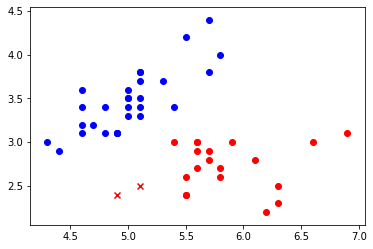

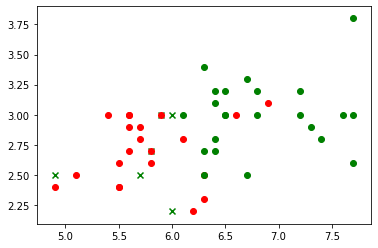

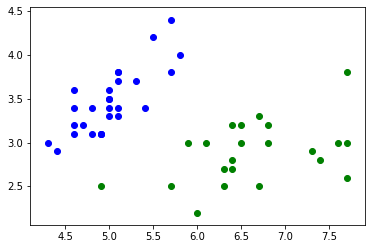

In [10]:
import urllib
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris = []
label_map = {}
label_cnt = 0
with urllib.request.urlopen(url) as f:
    for line in [l.decode('utf-8').strip() for l in f.readlines()]:
        if len(line) == 0:
            continue
        x1, x2, x3, x4, label = line.split(',')
        if label not in label_map:
            label_map[label] = label_cnt
            label_cnt += 1
        iris.append([float(x1), float(x2), float(x3), float(x4), label_map[label]])
np.random.shuffle(iris)

def get_data(l1, l2):
    iris_2labels = np.array([r for r in iris if r[4] == l1 or r[4] == l2])
    data_ = iris_2labels[:, [0,1,2,3]]
    labels_ = iris_2labels[:, 4]
    return data_, labels_

def fit_and_test(l1, l2):
    data, labels = get_data(l1, l2)
    n = len(data)
    data_l, labels_l = data[:n//2], labels[:n//2]
    data_t, labels_t = data[n//2:], labels[n//2:]

    rf = RandomForest(2, 10, 7, 5)
    rf.fit(data_l, labels_l)

    colors = {0: 'b', 1: 'r', 2: 'g'}
    for d, l_correct in zip(data_t, labels_t):
        l_predict = rf.predict(d)
        marker = 'o' if l_predict == l_correct else 'x'
        c = colors[l_correct]
        plt.scatter(d[0], d[1], c=c, marker=marker)
    plt.show()

fit_and_test(0, 1)
fit_and_test(1, 2)
fit_and_test(2, 0)

# 決定木回帰

In [2]:
import numpy as np

class MyNode:
    def __init__(self, value=None, i_feature=None, threshold=None):
        """
        Parameters
        ----------
        value : float
            ノードの代表値
        i_feature : int
            判定に用いる特徴量のインデックス
        threshold : float
            判別閾値
        """
        self.left = None
        self.right = None
        self.i_feature = i_feature
        self.threshold = threshold
        self.value = value
    
    def is_leaf(self):
        return self.threshold is None

class DecisionTreeRegression:
    def __init__(self, min_sample_leaf=1):
        """
        Parameters
        ----------
        min_sample_leaf : int
            決定木の1枚の葉が持つべきデータサンプルの最小件数
        """
        self.root = None
        self.min_sample_leaf = min_sample_leaf

    def predict(self, x):
        """
        Parameters
        ----------
        x : 分類したいデータ（d次元ベクトル）
        """
        stack = [self.root]
        while len(stack) > 0:
            node = stack.pop()
            if node.is_leaf():
                return node.value
            if x[node.i_feature] < node.threshold:
                stack.append(node.left)
            else:
                stack.append(node.right)
    
    def fit(self, data):
        """
        data : numpy array (2D)
            fitting 対象のデータ.
            末尾列の値を他の列の値から予測する決定木を学習する.
        """
        self.root = self.__dfs(data)
        
    def __dfs(self, data):
        inpurity = self.__inpurity(data)
        n = len(data)
        found_best = False
        best_gain = - float('inf')
        for i_f in range(len(data[0])-1):
            data_f = np.unique(data[:, i_f])  # 重複削除 & ソート
            th_arr = (data_f[:-1] + data_f[1:]) / 2.0  # 閾値候補として中間の値を取る
            for i_th in range(len(th_arr)):
                d_l, d_r = [], []
                for j in range(n):
                    if data[j][i_f] < th_arr[i_th]:
                        d_l.append(data[j])
                    else:
                        d_r.append(data[j])
                d_l, d_r = np.array(d_l), np.array(d_r)
                inpurity_l = self.__inpurity(d_l)
                inpurity_r = self.__inpurity(d_r)
                gain = inpurity - inpurity_l*len(d_l)/n - inpurity_r*len(d_r)/n
                if gain > best_gain and len(d_l) >= self.min_sample_leaf and len(d_r) >= self.min_sample_leaf:
                    best_gain = gain
                    best_threshold = th_arr[i_th]
                    best_i_feature = i_f
                    best_data_left, best_data_right = d_l, d_r
                    found_best = True

        # どう分けても条件を満たす gain が得られなくなったら終了
        if not found_best or best_gain == 0:
            return MyNode(value=np.average(data[:, -1]))

        node = MyNode(i_feature=best_i_feature, threshold=best_threshold)
        node.left = self.__dfs(best_data_left)
        node.right = self.__dfs(best_data_right)

        return node
    
    def __inpurity(self, data):
        """
        不純度として平均二乗誤差 (MSE) を用いる
        """
        return np.average((data[:, -1]-np.average(data[:, -1]))**2)

In [3]:
import numpy as np
import random

class RandomForestRegression:
    """
    Attributes
    ----------
    n_feature : int
        1つの決定木の学習に使う特徴量の種類数
    n_sample : int
        1つの決定木の学習に使うデータサンプル数
    n_tree = : int
        ランダムフォレストを構成する決定木の本数
    min_sample_leaf : int
        決定木の1枚の葉が持つべきデータサンプルの最小件数
    trees : list[object]
        決定木のリスト
    feature_indices : list[list[int]]
        各決定木で使用する特徴量のリスト
    """
    
    def __init__(self, n_feature, n_sample, n_tree, min_sample_leaf=1):
        self.n_feature = n_feature
        self.n_sample = n_sample
        self.n_tree = n_tree
        self.min_sample_leaf = min_sample_leaf
    
    def predict(self, x):
        value = 0
        for i in range(self.n_tree):
            x_fixed = x[self.feature_indices[i]]
            value += self.trees[i].predict(x_fixed)
        value /= self.n_tree
        return value

    def fit(self, data):
        """
        data : numpy array (2D)
            fitting 対象のデータ.
            末尾列の値を他の列の値から予測する決定木を学習する.
        """
        self.feature_indices = []
        self.trees = []
        d = len(data[0])
        for _ in range(self.n_tree):
            data_indices = random.sample(list(range(len(data))), self.n_sample)
            feature_indices = random.sample(list(range(d-1)), self.n_feature)
            feature_indices.append(-1)
            sampled_data = data[data_indices][:, feature_indices]
            tree = DecisionTreeRegression(self.min_sample_leaf)
            tree.fit(sampled_data)
            self.feature_indices.append(feature_indices)
            self.trees.append(tree)

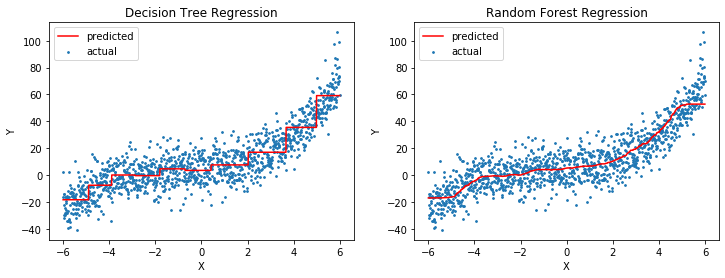

In [4]:
from matplotlib import pyplot as plt

# データ作成
N = 1000
x = np.arange(-6, 6, 10/N)
y = x + 0.5*x**2 + 0.2*x**3 + 5 + np.random.randn(len(x))*10

data = np.array([x, y]).T

# 学習
tree = DecisionTreeRegression(100)
tree.fit(data)
rf = RandomForestRegression(n_feature=1, n_sample=100, n_tree=100, min_sample_leaf=10)
rf.fit(data)

# 決定領域の描画
xp = np.arange(-6, 6, 0.01)
yp_tree = [tree.predict([x_]) for x_ in xp]
yp_rf = [rf.predict(np.array([x_])) for x_ in xp]
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12,4))
axL.scatter(x, y, s=3, label='actual')
axL.plot(xp, yp_tree, c='r', label='predicted')
axL.set_title('Decision Tree Regression')
axL.set_xlabel('X')
axL.set_ylabel('Y')
axL.legend()
axR.scatter(x, y, s=3, label='actual')
axR.plot(xp, yp_rf, c='r', label='predicted')
axR.set_title('Random Forest Regression')
axR.set_xlabel('X')
axR.set_ylabel('Y')
axR.legend()
plt.show()